## SEIR Simulation 

In [1]:
#import the basic libraries
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# load OD matrices
pkl_file = open('data/data_counties/od_counties.pkl', 'rb') # change to your desired directory
OD_matrices = pickle.load(pkl_file)
pkl_file.close()
OD_matrices = OD_matrices[:,:11,:11] 
print(OD_matrices.shape)
print(OD_matrices[0])
print(OD_matrices[2,:,:].shape)

(84, 11, 11)
[[0.8 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.1 0.8 0.1 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.1 0.8 0.1 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.1 0.8 0.1 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.1 0.8 0.1 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.1 0.8 0.1 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.1 0.8 0.1 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.8 0.1]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.8]]
(11, 11)


In [4]:
# create population 
df_befolkningstall_fylker = pd.read_csv("data/data_counties/Folkemengde_fylker.csv", delimiter=";", skiprows=1)
befolkningsarray= df_befolkningstall_fylker['Befolkning per 1.1. (personer) 2020'].to_numpy(dtype='float64')
pop = np.asarray([befolkningsarray for _ in range(84)])


In [5]:
# Set up model 
%run virus-sim.py  # Call python files in same directory

r = OD_matrices.shape[0]  # Simulation period (e.g 84)
n = pop.shape[1]          # Number of counties (e.g 11)
N = sum(befolkningsarray) # Total population (e.g 5367580)
initialInd = [2]          # Initial index of counties infected
initial = np.zeros(n)
initial[initialInd] = 50  # Number of infected people in each of the initial counties infected

model = Param(R0=2.4, DE= 5.6 * 12, DI= 5.2 * 12, I0=initial, HospitalisationRate=0.1, HospitalIters=15*12) # multiply by 12 as one day consists of 12 2-hours periods 

In [6]:
# run simulation
%run virus-sim.py

alpha = np.ones(OD_matrices.shape)  # One == no quarantene influence. Multiplied by real flow.
iterations = 3000                   # Number of simulations
res = {}                            # Dictionary with results for different cases 
inf = 50                            # Number of random infections
res['baseline'] = seir(model, pop, OD_matrices, alpha, iterations, inf)

In [7]:
# Print hospitalized information
print("Max number of hospitalised people: ", int(res["baseline"][0][:,4].max()))
print("Day with max hospitalised people: ", int(res["baseline"][0][:,4].argmax()/12)) # Divide by

Max number of hospitalised people:  222722
Day with max hospitalised people:  89


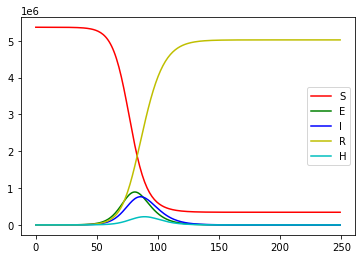

In [8]:
    def seir_plot(res):
        """ Plots the epidemiological curves
        Parameters:
            res: [3D matrix, compartment_id]
        """
        plt.plot(res[::12, 0], color='r', label='S')
        plt.plot(res[::12, 1], color='g', label='E')
        plt.plot(res[::12, 2], color='b', label='I')
        plt.plot(res[::12, 3], color='y', label='R')
        plt.plot(res[::12, 4], color='c', label='H')
        plt.legend()
        plt.show()
    
    seir_plot(res["baseline"][0])

## Spatial Visualisation

In [9]:
# import libraries
import pandas as pd
import geopandas as gpd
# import contextily as ctx # Is not installed with current .yml file 
import fiona as fi
from pyproj import CRS

In [12]:
# Sander cell
"""
fylker_path = 'data/data_counties/Basisdata_0000_Norge_25833_Fylker_GEOJSON.geojson'
print(fi.listlayers(fylker_path))
fylker = pd.read_json('data_norway/Basisdata_0000_Norge_25833_Fylker_GEOJSON.geojson')
for fylke in fylker["administrative_enheter.fylke"].loc["features"]:

    coordinates = fylke["geometry"]["coordinates"]
    fylkesnummer = fylke['properties']['fylkesnummer']
    navn = fylke["properties"]["navn"][0]["navn"]
    polygons[(navn, fylkesnummer)] = coordinates
"""

'\nfylker_path = \'data/data_counties/Basisdata_0000_Norge_25833_Fylker_GEOJSON.geojson\'\nprint(fi.listlayers(fylker_path))\nfylker = pd.read_json(\'data_norway/Basisdata_0000_Norge_25833_Fylker_GEOJSON.geojson\')\nfor fylke in fylker["administrative_enheter.fylke"].loc["features"]:\n\n    coordinates = fylke["geometry"]["coordinates"]\n    fylkesnummer = fylke[\'properties\'][\'fylkesnummer\']\n    navn = fylke["properties"]["navn"][0]["navn"]\n    polygons[(navn, fylkesnummer)] = coordinates\n'

In [14]:
crs = CRS.from_epsg(4326)
fylker = pd.read_json('data/data_counties/Basisdata_0000_Norge_25833_Fylker_GEOJSON.geojson')
epsg_fylke = int(fylker["administrative_enheter.fylke"].loc["crs"]["properties"]["name"].split(":")[1]) # epsg for kartverket sin data
crs_fylke = CRS.from_epsg(epsg_fylke)

In [16]:
# Load data and ensuring right epsg
norge_geojson = gpd.read_file("data/data_counties/Basisdata_0000_Norge_25833_Fylker_GEOJSON.geojson", layer='administrative_enheter.fylke')
norge_geojson.crs = {'init':f'epsg:{epsg_fylke}'}
norge_geojson.crs = crs_fylke
norge_geojson.head()


C:\Users\Peder\Anaconda3\envs\epidemics_2\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,objtype,samiskforvaltningsomrade,lokalid,navnerom,versjonid,datafangstdato,oppdateringsdato,datauttaksdato,opphav,fylkesnummer,navn,geometry
0,Fylke,False,173158173162,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20190913000000,20210104100647,None,38,"[ { ""navn"": ""Vestfold og Telemark"", ""rekkefolg...","POLYGON ((78548.430 6606728.760, 78556.900 660..."
1,Fylke,False,173153173160,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20190301000000,20210104100647,None,42,"[ { ""navn"": ""Agder"", ""rekkefolge"": """", ""sprak""...","POLYGON ((12650.920 6523939.770, 12654.850 652..."
2,Fylke,False,173157173156173161,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20190225000000,20210104100648,None,30,"[ { ""navn"": ""Viken"", ""rekkefolge"": """", ""sprak""...","POLYGON ((162857.290 6678845.090, 163199.630 6..."
3,Fylke,False,173152,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20200207000000,20210104100648,None,11,"[ { ""navn"": ""Rogaland"", ""rekkefolge"": """", ""spr...","POLYGON ((-92079.540 6636303.790, -96094.590 6..."
4,Fylke,None,173144,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20200207000000,20210104100648,None,18,"[ { ""navn"": ""Nordland"", ""rekkefolge"": """", ""spr...","POLYGON ((372929.380 7521632.830, 360585.200 7..."


In [17]:
norge_geojson.crs

<Projected CRS: EPSG:25833>
Name: ETRS89 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe - 12°E to 18°E and ETRS89 by country
- bounds: (12.0, 46.4, 18.01, 84.01)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [18]:

norge_geojson_3857 = norge_geojson.to_crs(epsg=3857)  # Convert to epsg=3857 to use contextily
west, south, east, north = norge_geojson_3857.unary_union.bounds

In [19]:
# declare baseline array storing the dynamics of the compartments 
baseline = res['baseline'][1][::12, :, :]
print(baseline.shape)
print(baseline)

(250, 5, 11)
[[[1.24116500e+06 6.93494000e+05 3.71335000e+05 ... 4.68702000e+05
   2.41235000e+05 2.43311000e+05]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 5.00000000e+01 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[8.33056911e+05 7.80584009e+05 5.95008067e+05 ... 3.64204259e+05
   3.21264036e+05 2.66903593e+05]
  [2.82387664e+00 5.09840873e+00 6.63694921e+00 ... 5.41200213e-03
   5.58959823e-04 4.57444440e-05]
  [6.05404917e+00 9.59460424e+00 1.15534595e+01 ... 1.10904085e-02
   1.15719389e-03 9.30620664e-05]
  [1.25638495e+00 1.98715166e+00 2.39030969e+00 ... 2.30342677e-03
   2.40347177e-04 1.93288689e-05]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.0000

In [20]:
# declare hopsitalisation array storing the dynamics of the hospitalised 
hosp = res['baseline'][0][::12, 4]
print(hosp.shape)
print(hosp)

(250,)
[0.00000000e+00 1.32984080e-01 6.39152752e-01 1.43520144e+00
 2.46636641e+00 3.70916659e+00 5.15947850e+00 6.82593922e+00
 8.72646922e+00 1.08865486e+01 1.33385304e+01 1.61216061e+01
 1.92822172e+01 2.28748009e+01 2.69628168e+01 3.16200361e+01
 3.67991130e+01 4.23591931e+01 4.84987930e+01 5.54062718e+01
 6.32600192e+01 7.22437847e+01 8.25572271e+01 9.44239794e+01
 1.08098695e+02 1.23873908e+02 1.42087228e+02 1.63129232e+02
 1.87452340e+02 2.15580943e+02 2.48123034e+02 2.85783623e+02
 3.29380213e+02 3.79860698e+02 4.38324029e+02 5.06044081e+02
 5.84497200e+02 6.75393962e+02 7.80715756e+02 9.02756855e+02
 1.04417274e+03 1.20803551e+03 1.39789721e+03 1.61786217e+03
 1.87266921e+03 2.16778487e+03 2.50950857e+03 2.90509077e+03
 3.36286471e+03 3.89239237e+03 4.50462455e+03 5.21207457e+03
 6.02900377e+03 6.97161606e+03 8.05825675e+03 9.30960856e+03
 1.07488748e+04 1.24019361e+04 1.42974618e+04 1.64669541e+04
 1.89446927e+04 2.17675484e+04 2.49746207e+04 2.86066562e+04
 3.27051994e+04 3

In [21]:
# find maximum hospitalisation value to make sure the color intensities in the animation are anchored against it
max_exp_ind = np.where(baseline[:, 1, :] == baseline[:, 1, :].max())[0].item()
max_exp_val = baseline[:, 1, :].max()
print(max_exp_ind, max_exp_val)

79 104786.86169081157


(256, 4)
[[1.         0.96078431 0.94117647 1.        ]
 [0.99987697 0.95820069 0.93748558 1.        ]
 [0.99975394 0.95561707 0.93379469 1.        ]
 ...
 [0.41917724 0.00369089 0.05294887 1.        ]
 [0.4115494  0.00184544 0.05196463 1.        ]
 [0.40392157 0.         0.05098039 1.        ]]


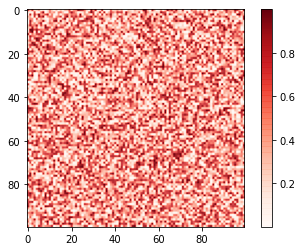

In [22]:
ncolors = 256
# get cmap
color_array = plt.get_cmap('Reds')(range(ncolors))
print(color_array.shape)
print(color_array)

# change alpha values
color_array[:, -1] = np.linspace(0.3, 1, ncolors)

# create colormap object
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap

map_object = LinearSegmentedColormap.from_list(name="Reds_transp", colors=color_array)

# register the colormap object
plt.register_cmap(cmap=map_object)

# plot some example data
fig, ax = plt.subplots()
h = ax.imshow(np.random.rand(100,100), cmap='Reds_transp')
plt.colorbar(mappable=h)

In [23]:
print(color_array)

[[1.         0.96078431 0.94117647 0.3       ]
 [0.99987697 0.95820069 0.93748558 0.3027451 ]
 [0.99975394 0.95561707 0.93379469 0.3054902 ]
 ...
 [0.41917724 0.00369089 0.05294887 0.9945098 ]
 [0.4115494  0.00184544 0.05196463 0.9972549 ]
 [0.40392157 0.         0.05098039 1.        ]]


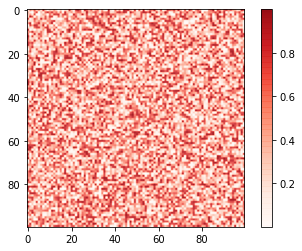

In [24]:
def trunc_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list('trunc({n}, {a:.2f}, {b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
                                                cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Reds_transp')
new_cmap = trunc_colormap(cmap, 0.0, .9)

# plot some example data
fig, ax = plt.subplots()
h = ax.imshow(np.random.rand(100,100), cmap=new_cmap)
plt.colorbar(mappable=h)

In [25]:
print("baseline dimensions: ", baseline.shape)
print("hosp dimensions: ", hosp.shape)

baseline dimensions:  (250, 5, 11)
hosp dimensions:  (250,)


In [26]:
baseline[0, 1, :]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [27]:
params = {"axes.labelcolor":"slategrey"}
plt.rcParams.update(params)
cmap = plt.cm.get_cmap("Blues")
blue = cmap(200)

from tqdm import tqdm

for time_step in tqdm(range(1,25)):
    
    norge_geojson_3857['exposed'] = baseline[time_step-1, 1, :]
    
    #plot
    fig, ax = plt.subplots(figsize=(14,14), dpi=72)
    norge_geojson_3857.loc[norge_geojson_3857.index==84, 'exposed'] = max_exp_val + 1
    norge_geojson_3857.plot(ax=ax, facecolor='none', edgecolor='gray', alpha=0.5, linewidth=0.5, zorder=2)
    norge_geojson_3857.plot(ax=ax, column='exposed', cmap=new_cmap, zorder=3)
    # add background
    # ctx.add_basemap(ax, attribution="", source=ctx.sources.ST_TONER_LITE, zoom='auto', alpha=0.6)
    
    ax.set_xlim(west, east)
    ax.set_ylim(south, north)
    ax.axis('off')
    plt.tight_layout()
    
    inset_ax = fig.add_axes([0.6, 0.14, 0.37, 0.27])
    inset_ax.patch.set_alpha(0.5)
    
    inset_ax.plot(baseline[:time_step, 0].sum(axis=1), label="susceptible", color=blue, ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(baseline[:time_step, 1].sum(axis=1), label="exposed", color='g', ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(baseline[:time_step, 2].sum(axis=1), label="infectious", color='r', ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(baseline[:time_step, 3].sum(axis=1), label="recovered", color='y', ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(hosp[:time_step], label="hospitalised", color='purple', ls='-', lw=1.5, alpha=0.8)
    
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 0].sum(), color=blue, s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 1].sum(), color='g', s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 2].sum(), color='r', s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 3].sum(), color='y', s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), hosp[(time_step-1)], color='purple', s=50, alpha=0.2)
    
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 0].sum(), color=blue, s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 1].sum(), color='g', s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 2].sum(), color='r', s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 3].sum(), color='y', s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), hosp[(time_step-1)], color='purple', s=20, alpha=0.8)
    
    inset_ax.fill_between(np.arange(0, time_step), np.maximum(baseline[:time_step, 0].sum(axis=1), \
                                                             baseline[:time_step, 3].sum(axis=1)), alpha=0.035, color='r')
    inset_ax.plot([time_step, time_step], [0, max(baseline[(time_step-1), 0].sum(), \
                                              baseline[(time_step-1), 3].sum())], ls='--', lw=0.7, alpha=0.8, color='r')
    
    inset_ax.set_ylabel('Population', size=18, alpha=1, rotation=90)
    inset_ax.set_xlabel('Days', size=18, alpha=1)
    inset_ax.yaxis.set_label_coords(-0.15, 0.55)
    inset_ax.tick_params(direction='in', size=10)
    inset_ax.set_xlim(-4, 254)
    inset_ax.set_ylim(-24000, 6024000)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    inset_ax.grid(alpha=0.4)
    
    inset_ax.spines['right'].set_visible(False)
    inset_ax.spines['top'].set_visible(False)
    
    inset_ax.spines['left'].set_color('darkslategrey')
    inset_ax.spines['bottom'].set_color('darkslategrey')
    inset_ax.tick_params(axis='x', colors='darkslategrey')
    inset_ax.tick_params(axis='y', colors='darkslategrey')
    plt.legend(prop={'size':14, 'weight':'light'}, framealpha=0.5)
    plt.title("Norway Covid-19 spreading on day: {}".format(time_step), fontsize=18, color= 'dimgray')
    plt.savefig("plots/plots_counties/flows_{}.jpg".format(time_step), dpi=fig.dpi)
    plt.close()

  0%|          | 0/24 [00:01<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'Plots_Norway/flows_1.jpg'

In [218]:
import re

def sort_in_order( l ):
    """ sorts a given iterable
    
    l : iterable to be sorted"""
    
    convert = lambda text: int(text) if text.isdigit() else text
    alphanumeric_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanumeric_key)

from os import listdir

filenames = listdir("plots/plots_counties/")
filenames = sort_in_order(filenames)
print(filenames)

['flows_1.jpg', 'flows_2.jpg', 'flows_3.jpg', 'flows_4.jpg', 'flows_5.jpg', 'flows_6.jpg', 'flows_7.jpg', 'flows_8.jpg', 'flows_9.jpg', 'flows_10.jpg', 'flows_11.jpg', 'flows_12.jpg', 'flows_13.jpg', 'flows_14.jpg', 'flows_15.jpg', 'flows_16.jpg', 'flows_17.jpg', 'flows_18.jpg', 'flows_19.jpg', 'flows_20.jpg', 'flows_21.jpg', 'flows_22.jpg', 'flows_23.jpg', 'flows_24.jpg', 'od_counties.pkl']


In [220]:
import imageio
from tqdm import tqdm
with imageio.get_writer('Covid_19_counties.gif', mode='I', fps=4) as writer:
    for filename in tqdm(filenames):
        image = imageio.imread('plots/plots_counties/{}'.format(filename))
        writer.append_data(image)

 96%|█████████▌| 24/25 [00:07<00:00,  3.06it/s]


ValueError: Could not find a format to read the specified file in single-image mode